In [1]:
# Create a GNN model for 1D data
#pip install torch_geometric --user --quiet
#pip install torch --user --quiet

In [2]:
# Importing libraries
import torch
import torch.nn.functional as F
import torch_geometric as pyg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


In [105]:
class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [106]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

In [117]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        dim=1, # dimension of the world, typical 2D or 3D
    ):
        super().__init__()
        self.node_in = MLP(dim, hidden_size, hidden_size, 3)
        self.edge_in = MLP(1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])


    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = data.pos
        node_feature = self.node_in(node_feature)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out

# Data

In [118]:
def preprocess(position, edge_distance, metadata):
    """Preprocess a trajectory and construct the graph"""

    # construct the graph based on the distances between particles
    n_particle = position.size
    edge_index = pyg.nn.radius_graph(position, metadata["default_connectivity_radius"])

    # return the graph with features
    graph = pyg.data.Data(
        x=position,
        edge_index=edge_index,
        edge_attr=edge_distance,
    )
    return graph

In [119]:
position_1 = np.arange(0,10)
edge_distance_1 = np.diff(position_1)
metadata_1 = {"default_connectivity_radius": 1.1}
position_1 = torch.tensor(position_1, dtype=torch.float32).view(-1,1)
edge_distance_1 = torch.tensor(edge_distance_1, dtype=torch.float32).view(-1, 1)

In [120]:
graph = preprocess(position_1, edge_distance_1, metadata_1)

In [121]:
import networkx as nx

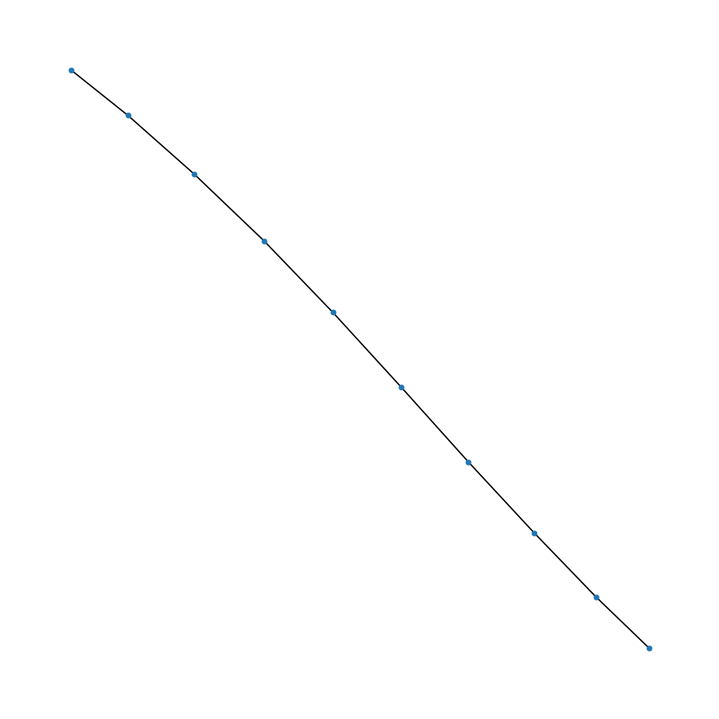

In [122]:
# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(7, 7))
nx.draw(nx_graph, node_size=10)
plt.show()

In [147]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data, metadata):
        super().__init__()

        self.data = data
        self.metadata = metadata

    def __len__(self):
        return len(self.data["position"])


    def get(self, idx):
        # load corresponding data for this time slice
        position = self.data["position"][idx]
        edge_distance = self.data["edge_distance"][idx]
    
        # construct the graph
        with torch.no_grad():
            graph = preprocess(position, edge_distance, self.metadata)
        return graph

In [148]:
def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for data in valid_loader:
            data = data.cuda()
            pred = simulator(data)
            mse = ((pred - data.y) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.y) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count

In [160]:
from tqdm import tqdm

def train(params, simulator, train_loader):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
            optimizer.zero_grad()
            pred = simulator(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))


            # save model
            if total_step % params["save_interval"] == 0:
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list

In [161]:
# build model
simulator = LearnedSimulator()

In [164]:
# Train dataset
train_dataset = OneStepDataset({"position":position_1, "edge_distance":edge_distance_1}, metadata_1)
train_dataloader = pyg.data.DataLoader(train_dataset)

C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [174]:
train_params = {"lr": 1e-3, "epoch": 100, "save_interval": 1000}
for i in range(train_params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {i}", total=len(train_dataloader))
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
                print(data)

Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s]


NotImplementedError: 